# Sentiment on Economic Debt in Zambia Using GDELT Dataa

In [57]:
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## BigQUery API setup 

In [2]:


key_path = "/home/sitwala/linuxdevs/DSI/twist3/ageless-airship-347507-d17d039b4b81.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [3]:
# list the tables in the project

dataset_ref = client.dataset("gdeltv2", project="gdelt-bq")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

academicliteraturegkg
cloudvision
cloudvision_partitioned
cloudvision_webentitygraph_20191020
domainsbycountry_alllangs_april2015
eventmentions
eventmentions_partitioned
events
events-2021-12-08T11_17_17
events_partitioned
gal
gdg_partitioned
geg_g1
geg_gcnlapi
geg_gcnlapisent
geg_iatv
gegv2_iatv
gemg
gfg_linguistic1grams_20190831
gfg_linguistic2grams_20190831
gfg_linguisticinventory_20190901
gfg_outlet1grams_20190831
gfg_outlet2grams_20190831
gfg_partitioned
ggg
gkg
gkg_partitioned
gkg_socialoutlinks
gng
gqg
grg_dtn
grg_vcn
grg_vcn_nlpapi
gsg
gsg_docembed
gsg_iatvsentembed
iaradio_1grams
iaradio_2grams
iaradio_3grams
iaradio_4grams
iaradio_5grams
iatv_1grams
iatv_1gramsv2
iatv_2grams
iatv_2gramsv2
iatv_3gramsv2
iatv_4gramsv2
iatv_5gramsv2
iatv_aif_captime
iatv_aif_vidtime
iatv_lowerthird
iatv_lowerthirdclusters
iatv_showinventory
iatv_timeinventory
iatvgkg
readability
readability_iatv
vgeg_iatv
vgegv2_iatv
web_1grams
web_2grams
web_pos
webngrams


In [18]:
# check columns in the event data and save to CSV
query = """
        SELECT *
        FROM `gdelt-bq.gdeltv2.INFORMATION_SCHEMA.COLUMNS`
        where table_catalog="gdelt-bq" and table_schema="gdeltv2" and table_name="events"
        """
query_job = client.query(query)
columns = query_job.to_dataframe()
columns.to_csv("columns_event.csv")

In [17]:
# check columns in the gkg data and save to CSV
query = """
        SELECT *
        FROM `gdelt-bq.gdeltv2.INFORMATION_SCHEMA.COLUMNS`
        where table_catalog="gdelt-bq" and table_schema="gdeltv2" and table_name="gkg"
        """

# Set use_legacy_sql to True to use legacy SQL syntax.
job_config = bigquery.QueryJobConfig(use_legacy_sql=False)

query_job = client.query(query, job_config=job_config)
columns = query_job.to_dataframe()
columns.to_csv("columns_gkg.csv")

In [19]:
# function to run queries

def run_bigquery(query, legacy= False):
    job_config = bigquery.QueryJobConfig(use_legacy_sql=legacy)

    query_job = client.query(query, job_config=job_config)
    return  query_job.to_dataframe()
    

## Load Dataset

In [167]:
query_zambia_full = """
SELECT  *
FROM (
select REGEXP_EXTRACT(SPLIT(V2Locations,';'),r'^[1]#(.*?)#ZA#') as location,  GKGRECORDID, Quotations, V2Tone, Persons, V2Themes
from [gdelt-bq.gdeltv2.gkg_partitioned]
where _PARTITIONTIME >= TIMESTAMP("2021-01-1") and  _PARTITIONTIME <= TIMESTAMP("2022-04-17") and V2Themes like '%ECON_DEBT%'
)
where location is not null
"""


In [20]:
# function is commented out to avoid running it by mistake. The full query scans about 250 GB 

'''
#data = run_bigquery(query_zambia_full,legacy=True)
data.to_parquet('zambia_full_year.parquet.gzip',
              compression='gzip')
data.head()
'''

"\n#data = run_bigquery(query_zambia_full,legacy=True)\ndata.to_parquet('zambia_full_year.parquet.gzip',\n              compression='gzip')\ndata.head()\n"

In [21]:

data = pd.read_parquet('zambia_full_year.parquet.gzip')
data.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes
0,Zambia,20210119181500-T119,None,"1.56657963446475,2.34986945169713,0.7832898172...",None,"TAX_FNCACT_DIRECTOR,1056;NEGOTIATIONS,2033;TAX..."
1,Zambia,20210119160000-T209,None,"1.55440414507772,2.33160621761658,0.7772020725...",None,"TAX_FNCACT_DIRECTOR,1066;NEGOTIATIONS,2057;TAX..."
2,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P..."
3,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P..."
4,Zambia,20210616134500-1398,None,"0.426439232409382,2.13219616204691,1.705756929...",None,"SLFID_ECONOMIC_DEVELOPMENTAID,2610;SLFID_ECONO..."


In [7]:
# check if the record IDs repeat

data['GKGRECORDID'].duplicated().any()

True

In [22]:
# remove duplicate records

data = data.drop_duplicates(subset=['GKGRECORDID']).copy()
data['GKGRECORDID'].duplicated().any()

False

In [9]:
# copy dataframe to df for different operations

df =data.copy()


## Add Date Columns and Average Tone 

In [23]:
def get_date_from_code(text):
    # function takes the GKGRECORDID and returns the date
    date = text[:8]
    date = datetime.strptime(date, '%Y%m%d')
    
    return pd.to_datetime(date)

def get_tone(text,index):
    # function takes the tone column (text) and can return a tone metric based on index
     # average tone index 0
     # average polarity index 3
     return float(text.split(sep=",")[index])

In [26]:
# Add Average Tone column from V2Tone
# Add Average polarity

df["date"] = df["GKGRECORDID"].apply(lambda x: get_date_from_code(x))
df["Avg_tone"] = df["V2Tone"].apply(lambda x: get_tone(x,0))
df["polarity"] = df["V2Tone"].apply(lambda x: get_tone(x,3))


df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df["date"].apply(lambda x: x.strftime('%Y-%m'))
df.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
0,Zambia,20210119181500-T119,None,"1.56657963446475,2.34986945169713,0.7832898172...",None,"TAX_FNCACT_DIRECTOR,1056;NEGOTIATIONS,2033;TAX...",2021-01-19,1.566580,3.133159,2021-01
1,Zambia,20210119160000-T209,None,"1.55440414507772,2.33160621761658,0.7772020725...",None,"TAX_FNCACT_DIRECTOR,1066;NEGOTIATIONS,2057;TAX...",2021-01-19,1.554404,3.108808,2021-01
2,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P...",2021-01-19,-7.572383,9.354120,2021-01
4,Zambia,20210616134500-1398,None,"0.426439232409382,2.13219616204691,1.705756929...",None,"SLFID_ECONOMIC_DEVELOPMENTAID,2610;SLFID_ECONO...",2021-06-16,0.426439,3.837953,2021-06
6,Zambia,20211031083000-T817,None,"2.35294117647059,5,2.64705882352941,7.64705882...",None,"WB_1305_HEALTH_SERVICES_DELIVERY,5235;ENV_HYDR...",2021-10-31,2.352941,7.647059,2021-10


In [27]:
# check for nulls in the Avgtone
df.Avg_tone.isna().sum()

0

In [28]:
grouped_date = df.groupby("date", dropna=True, as_index= False)["Avg_tone"].mean()
grouped_date.head() 

,date,Avg_tone
0,2021-01-01,-3.723040
1,2021-01-02,-3.951555
2,2021-01-03,-2.388748
3,2021-01-04,-2.171266
4,2021-01-05,-4.362609


In [29]:
grouped_date = df.groupby("date", dropna=True, as_index= False)["Avg_tone"].mean().reset_index(0,drop=True)
grouped_date["rolling_avg_tone"] = grouped_date["Avg_tone"].rolling(14, center = True).median()
df_shifted = grouped_date[7:]
df_shifted.head()

,date,Avg_tone,rolling_avg_tone
7,2021-01-08,-2.812865,-2.513610
8,2021-01-09,-2.056560,-2.280007
9,2021-01-10,-1.787765,-2.113913
10,2021-01-11,-1.598138,-1.944892
11,2021-01-12,-1.187090,-1.944892


## EDA on the time-series tone

In [30]:
df.Avg_tone.describe()

count    7623.000000
mean       -1.948651
std         2.838491
min       -15.714286
25%        -3.893010
50%        -1.880878
75%         0.000000
max         9.090909
Name: Avg_tone, dtype: float64

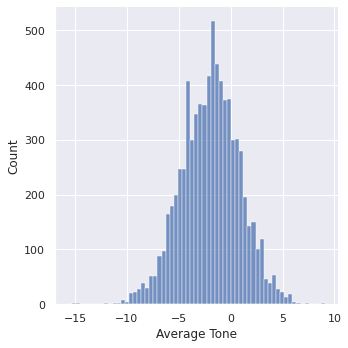

In [36]:
sns.set()
ax = sns.displot(df.Avg_tone)
plt.xlabel("Average Tone")
plt.savefig("../images/tone_dist.png")

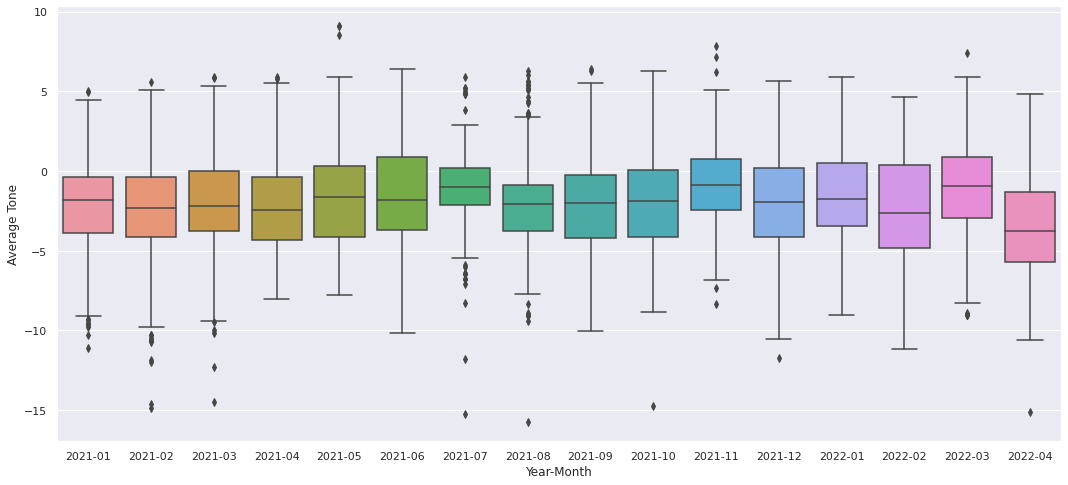

In [40]:
sns.set()
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(x="month_year", y="Avg_tone", data=df.sort_values(by="month_year"), ax = ax)
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_boxplots.png")

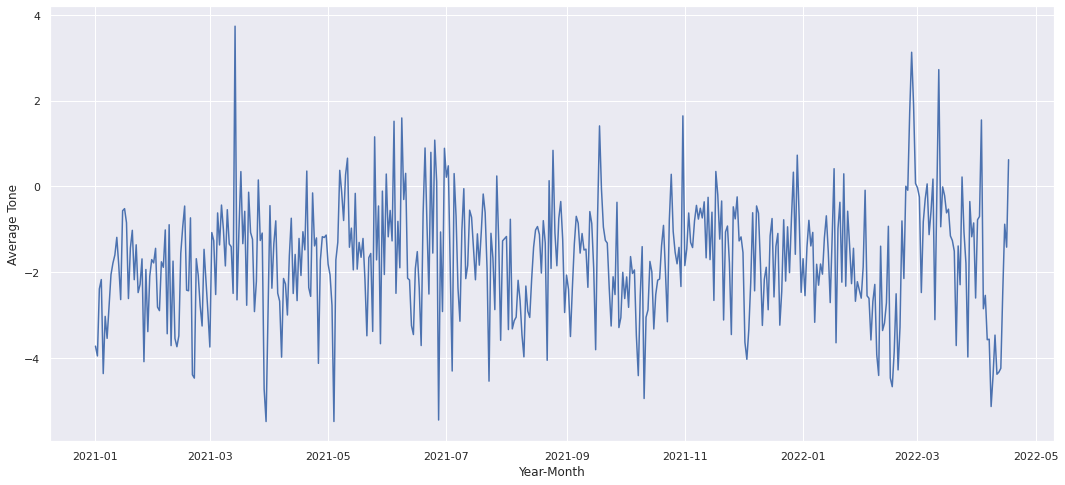

In [44]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=grouped_date.date, y=grouped_date.Avg_tone, ax = ax)
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_time.png")

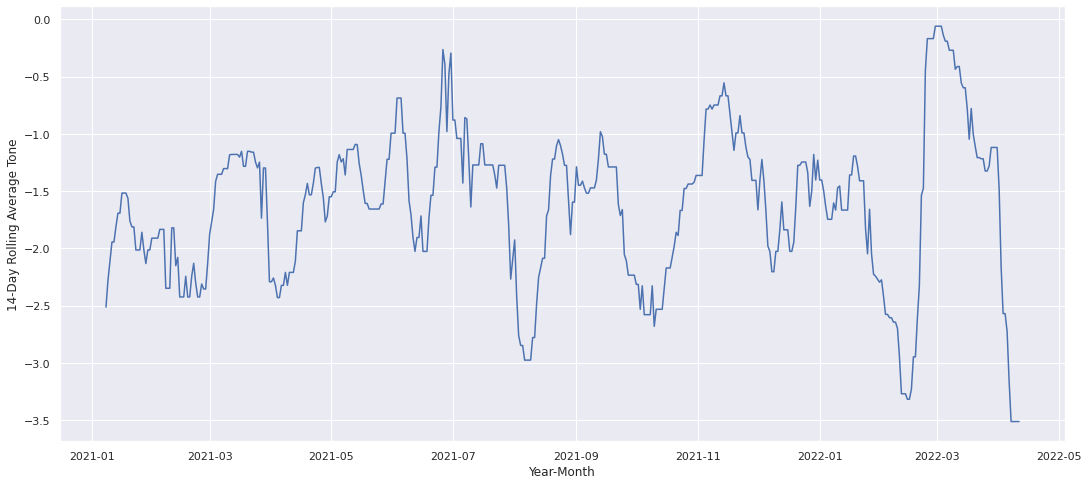

In [45]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=df_shifted.date, y=df_shifted.rolling_avg_tone)
plt.xlabel("Year-Month")
plt.ylabel("14-Day Rolling Average Tone")
plt.savefig("../images/tone_time_rolling.png")


# Compare Sentiment for Two Presidents

In [47]:
# create dataframes for the two presidents
# we check for the presidents' names in the "Persons" column

lungu_df = df[df['Persons'].str.contains("edgar lungu|president lungu", regex=True, na = False) & (df['Persons'].str.contains("hakainde hichilema|hh|president hichilema", regex=True, na = False)  == False)]
hh_df = df[df['Persons'].str.contains("hakainde hichilema|hh|president hichilema", regex=True, na = False) & (df['Persons'].str.contains("edgar lungu|president lungu", regex=True, na = False) == False)]

In [48]:
lungu_df.Avg_tone.describe()

count    275.000000
mean      -2.234931
std        2.332609
min      -11.783439
25%       -3.425246
50%       -1.720841
75%       -1.125704
max        6.018519
Name: Avg_tone, dtype: float64

In [49]:
hh_df.Avg_tone.describe()

count    315.000000
mean      -1.923895
std        2.778922
min       -9.009009
25%       -3.910252
50%       -2.281369
75%        0.185720
max        5.643739
Name: Avg_tone, dtype: float64

In [50]:
lungu_tones =  pd.DataFrame({"president": "Edgar Lungu", "Avg_tone": lungu_df.Avg_tone})
hh_tones = pd.DataFrame({"president": "Hakainde Hichilema", "Avg_tone": hh_df.Avg_tone})

combined = pd.concat([lungu_tones,hh_tones], axis=0)

combined.head()

,president,Avg_tone
3919,Edgar Lungu,-4.193548
3924,Edgar Lungu,6.018519
3929,Edgar Lungu,-2.189781
3934,Edgar Lungu,-3.389831
3935,Edgar Lungu,-3.280840


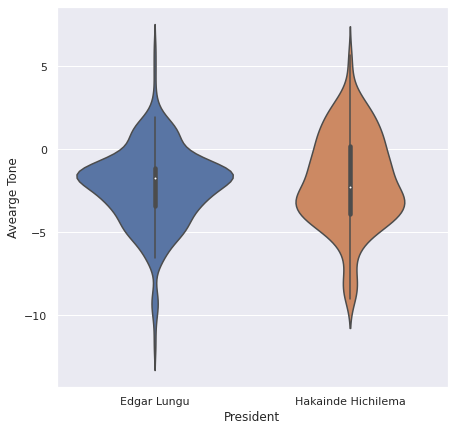

In [93]:
fig, ax = plt.subplots(figsize=(7,7))
sns.violinplot(x="president", y="Avg_tone", data = combined, ax = ax)
plt.xlabel("President")
plt.ylabel("Avearge Tone")
plt.savefig("../images/tone_violin_presidents.png")

# Outlier flagging on the daily tone

In [55]:
grouped_date.head()

,date,Avg_tone,rolling_avg_tone
0,2021-01-01,-3.723040,NaN
1,2021-01-02,-3.951555,NaN
2,2021-01-03,-2.388748,NaN
3,2021-01-04,-2.171266,NaN
4,2021-01-05,-4.362609,NaN


In [91]:
# fit and predict using isolation forest
# Tune contamination until the outliers make sense visually

clf = IsolationForest(contamination=0.024, random_state=0)
clf.fit(grouped_date[["Avg_tone"]] )
pred = clf.predict(grouped_date[["Avg_tone"]])

/home/sitwala/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [89]:
grouped_date["outlier"] = pd.Series(pred)
grouped_date.head()

,date,Avg_tone,rolling_avg_tone,outlier
0,2021-01-01,-3.723040,NaN,1
1,2021-01-02,-3.951555,NaN,1
2,2021-01-03,-2.388748,NaN,1
3,2021-01-04,-2.171266,NaN,1
4,2021-01-05,-4.362609,NaN,1


Text(0, 0.5, 'Average Tone')

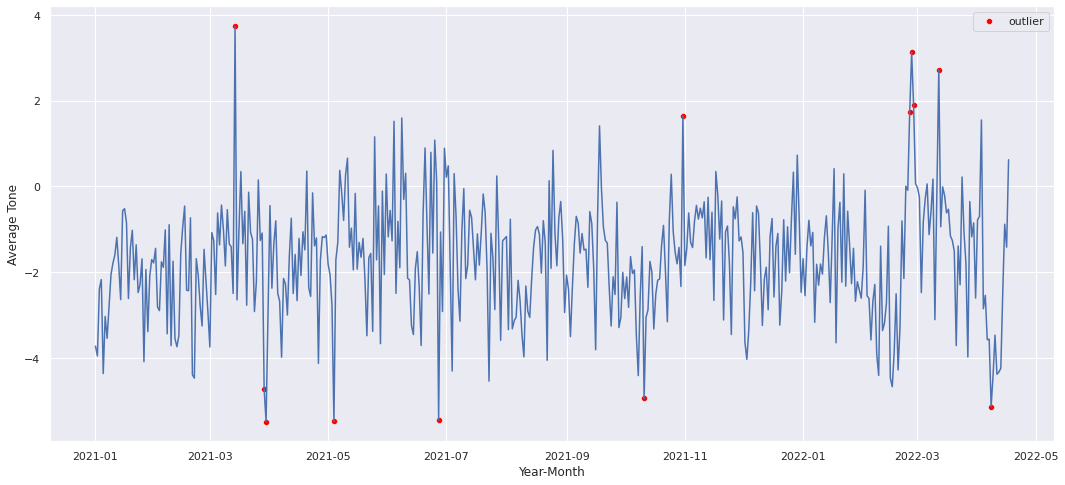

In [133]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=grouped_date.date, y=grouped_date.Avg_tone ,ax = ax)
sns.scatterplot(data = grouped_date[grouped_date["outlier"]== -1],x="date", y="Avg_tone" , sizes = 50,ax = ax, label = "outlier", color = "red")
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")

# Topic Modelling on Qoutations


In [120]:
# filter where we have quotations

df_quotes = df[df.Quotations.notnull()]
df_quotes.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
20599,Zambia,20210727234500-1452,259|235||Our political leaders have suddenly d...,"-6.40478223740393,1.3663535439795,7.7711357813...",pat utomi;akinwunmi adesina;ayo oyoze baje;olu...,"BAN,6161;ECON_ELECTRICALGENERATION,2940;EDUCAT...",2021-07-27,-6.404782,9.137489,2021-07
20601,Zambia,20210728040000-663,281|235||Our political leaders have suddenly d...,"-6.45994832041344,1.37812230835487,7.838070628...",pat utomi;akinwunmi adesina;ayo oyoze baje;olu...,"BAN,6143;ECON_ELECTRICALGENERATION,2940;EDUCAT...",2021-07-28,-6.459948,9.216193,2021-07
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02
20604,Zambia,20210322181500-2050,505|33||We are going UP UP UP UP UP UP UP#654|...,"-1.78335535006605,2.11360634081902,3.896961690...",astra zeneca;joe biden,"ARMEDCONFLICT,8192;EPU_CATS_NATIONAL_SECURITY,...",2021-03-22,-1.783355,6.010568,2021-03
20605,Zambia,20220124140000-187,4130|27||human rights-based recovery#10371|55|...,"-0.328715660953276,3.28246067151914,3.61117633...",agence fran;john campbell;tangi sala;joe biden...,"TAX_AIDGROUPS_INTERNATIONAL_CRISIS_GROUP,11098...",2022-01-24,-0.328716,6.893637,2022-01


In [135]:
test = df_quotes[df_quotes.Persons.str.contains("hh|president lungu|hichilema|hakainde|edgar lungu", na = False)]
test.sort_values(by="date", ascending= True)

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
23398,Zambians,20210107021500-737,4501|71||activate your troops and deal with no...,"-2.56578947368421,4.29824561403509,6.864035087...",chama fumba;sean tembo;judith kabemba;maiko zu...,"RURAL,12489;RURAL,17241;RURAL,19570;TAX_FNCACT...",2021-01-07,-2.565789,11.162281,2021-01
21865,Zambia,20210119143000-1174,2271|29||mining investors who cry foul,"-1.45530145530146,1.87110187110187,3.326403326...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.455301,5.197505,2021-01
21876,Zambia,20210119151500-540,2273|29||mining investors who cry foul,"-1.45530145530146,1.87110187110187,3.326403326...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.455301,5.197505,2021-01
21852,Zambia,20210119213000-78,2025|29||mining investors who cry foul,"-1.12866817155756,2.03160270880361,3.160270880...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.128668,5.191874,2021-01
21616,Zambia,20210119170000-1176,1185|28||I can work with this country,"-2.95275590551181,1.37795275590551,4.330708661...",richard musukwa;edgar lungu;taonga clifford mi...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2021-01-19,-2.952756,5.708661,2021-01
...,...,...,...,...,...,...,...,...,...,...
20806,Zambia,20220322024500-19,918|41||has more responsibility and opportunit...,"-2.5,1.84210526315789,4.34210526315789,6.18421...",ismail omar guelleh;thongloun sisoulith;mark s...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2022-03-22,-2.500000,6.184211,2022-03
20809,Zambia,20220323021500-820,918|41||has more responsibility and opportunit...,"-2.5,1.84210526315789,4.34210526315789,6.18421...",ismail omar guelleh;thongloun sisoulith;mark s...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2022-03-23,-2.500000,6.184211,2022-03
24187,Zambia,20220405113000-1263,751|35||in his interest to serve the public#21...,"-1.33729569093611,2.22882615156018,3.566121842...",sean tembo;al jazeera hichilema;uhuru kenyatta...,"TAX_FNCACT_CANDIDATES,3421;GENERAL_GOVERNMENT,...",2022-04-05,-1.337296,5.794948,2022-04
24176,Zambia,20220405103000-1171,317|35||in his interest to serve the public#17...,"-1.52027027027027,2.53378378378378,4.054054054...",sean tembo;uhuru kenyatta;hakainde hichilema;c...,"TAX_FNCACT_CANDIDATES,3040;GENERAL_GOVERNMENT,...",2022-04-05,-1.520270,6.587838,2022-04


<AxesSubplot:xlabel='date', ylabel='Avg_tone'>

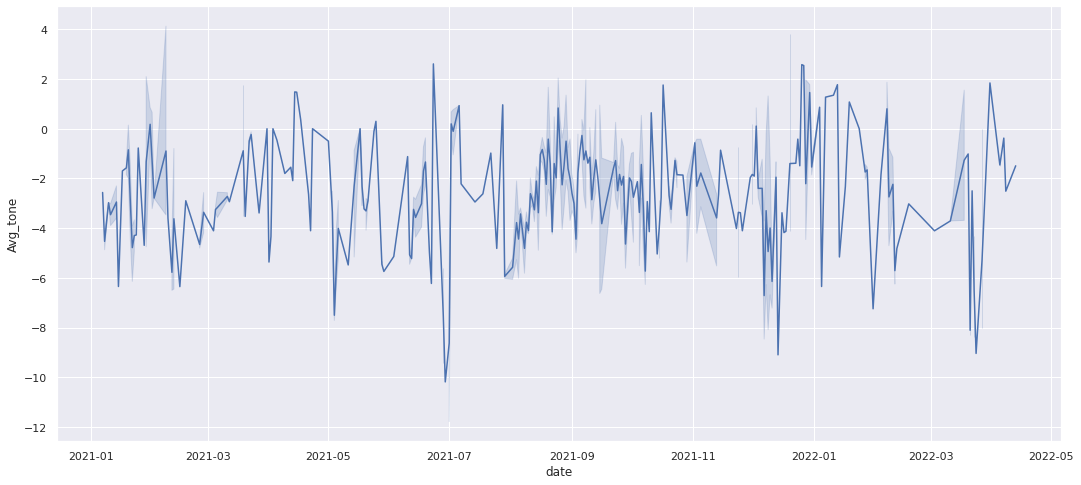

In [129]:
sns.set()
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x = test.date, y = test.Avg_tone)